# Weekly Modeling

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn import metrics
from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima

from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation,rmse, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot


plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

In [264]:
#df = pd.read_csv('../capstone-data/daily-merged.csv')
df = pd.read_csv('../capstone-data/weekly-merged.csv')

In [265]:
df

,date,bus,rail_boardings,total_rides,prcp,tmax,tmin,gas_open,gas_close,gas_volume,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,total_daily_doses,total_daily_cum,first_dose_daily,first_dose_cum,first_dose_percent_pop,vax_series_completed_daily,vax_series_cum,vax_series_percent,crash_occurrences,damage_indicator,gas_price
0,2001-01-01,297192.0,126455.0,423647.0,0.000000,26.000000,13.000000,0.794000,0.795000,14697.000000,5.870000,5.580000,5.110000,4.870000,4.820000,4.760000,4.970000,4.920000,5.460000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.487
1,2001-01-08,5304650.0,3162199.0,8466849.0,0.000000,31.142857,17.285714,0.811429,0.817157,17527.571429,5.354286,5.170000,4.768571,4.682857,4.682857,4.735714,4.992857,4.974286,5.522857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.477
2,2001-01-15,5618534.0,3271759.0,8890293.0,0.037143,35.571429,26.142857,0.872286,0.886529,14497.714286,5.308571,5.200000,4.887143,4.824286,4.835714,4.898571,5.164286,5.174286,5.680000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.569
3,2001-01-22,5926682.0,3479888.0,9406570.0,0.000000,29.285714,17.714286,0.868500,0.875129,16529.142857,5.281429,5.155714,4.825714,4.778571,4.788571,4.851429,5.147143,5.195714,5.662857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.546
4,2001-01-29,5894412.0,3453667.0,9348079.0,0.120000,32.142857,20.285714,0.877500,0.880143,14571.857143,5.202857,5.087143,4.817143,4.788571,4.814286,4.948571,5.240000,5.301429,5.757143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2021-11-08,2760963.0,2012026.0,4772989.0,0.000000,55.142857,35.714286,2.328500,2.319557,80192.714286,0.050000,0.070000,0.148571,0.422857,0.702857,1.098571,1.361429,1.507143,1.927143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.714286,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,11979155.0,198543.0,24.205714,33.50,44.344286,45.32,37.5,11094.714286,24238965.0,2880.857143,12262639.0,0.650286,1698.714286,11295344.0,0.599000,2147.0,2.579138,3.616
1089,2021-11-15,2554455.0,1914422.0,4468877.0,0.000000,47.285714,36.142857,2.322543,2.321886,71787.000000,0.048571,0.067143,0.167143,0.507143,0.827143,1.217143,1.448571,1.564286,1.971429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,12129124.0,199443.0,19.440000,27.38,41.670000,42.26,37.5,13830.428571,24871296.0,5320.714286,12486916.0,0.662143,1562.285714,11374567.0,0.603143,2099.0,2.590238,3.557
1090,2021-11-22,2670145.0,2028963.0,4699108.0,0.000000,48.857143,31.714286,2.297986,2.260029,45781.285714,0.050000,0.062857,0.181429,0.538571,0.870000,1.245714,1.482857,1.581429,1.998571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,

In [266]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('W-Mon')
df = df.drop(df.tail(1).index)
df = df.drop(df.head(1).index)

# Linear Model Setup

Testing lags for future modeling.

In [267]:
test = df[['total_rides']].copy()
test['test_lags'] = test['total_rides'].shift(52)
test.corr()

,total_rides,test_lags
total_rides,1.000000,0.690461
test_lags,0.690461,1.000000


In [268]:
rides = df[['total_rides']].copy()

In [269]:
rides['lag_1'] = rides['total_rides'].shift(1)
rides['lag_2'] = rides['total_rides'].shift(2)
rides['lag_3'] = rides['total_rides'].shift(3)
rides['lag_4'] = rides['total_rides'].shift(4)
rides['lag_12'] = rides['total_rides'].shift(12)
rides['lag_26'] = rides['total_rides'].shift(26)
rides['lag_52'] = rides['total_rides'].shift(52)

rides['time'] = range(0, rides.shape[0])

In [270]:
rides.corr()

,total_rides,lag_1,lag_2,lag_3,lag_4,lag_12,lag_26,lag_52,time
total_rides,1.000000,0.918273,0.881533,0.856505,0.858138,0.749586,0.721652,0.690461,-0.409600
lag_1,0.918273,1.000000,0.917959,0.880912,0.855849,0.737723,0.709054,0.618182,-0.407181
lag_2,0.881533,0.917959,1.000000,0.917578,0.880385,0.742527,0.701021,0.589805,-0.405140
lag_3,0.856505,0.880912,0.917578,1.000000,0.917201,0.757189,0.700055,0.570567,-0.402998
lag_4,0.858138,0.855849,0.880385,0.917201,1.000000,0.776162,0.716322,0.590719,-0.400959
lag_12,0.749586,0.737723,0.742527,0.757189,0.776162,1.000000,0.722518,0.547633,-0.384462
lag_26,0.721652,0.709054,0.701021,0.700055,0.716322,0.722518,1.000000,0.668876,-0.348897
lag_52,0.690461,0.618182,0.589805,0.570567,0.590719,0.547633,0.668876,1.000000,-0.253563
time,-0.409600,-0.407181,-0.405140,-0.402998,-0.400959,-0.384462,-0.348897,-0.253563,1.000000


## Linear TimeSeries Model

In [271]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides'}),
                                                 rides['total_rides'],
                                                 test_size=.25,
                                                 shuffle=False)

In [272]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_2,lag_3,lag_4,lag_12,lag_26,lag_52,time
date,,,,,,,,,
2001-01-08,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-15,1.0,8466849.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2001-01-22,1.0,8890293.0,8466849.0,NaN,NaN,NaN,NaN,NaN,2
2001-01-29,1.0,9406570.0,8890293.0,8466849.0,NaN,NaN,NaN,NaN,3
2001-02-05,1.0,9348079.0,9406570.0,8890293.0,8466849.0,NaN,NaN,NaN,4


In [273]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     297.9
Date:                Sun, 06 Feb 2022   Prob (F-statistic):          5.35e-228
Time:                        23:43:01   Log-Likelihood:                -11060.
No. Observations:                 766   AIC:                         2.214e+04
Df Residuals:                     757   BIC:                         2.218e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.722e+05   3.49e+05     -2.213      0.027   -1.46e+06   -8.73e+04
lag_1          0.2032      0.025      8.268      0.000       0.155       0.251
lag_2          0.0235      0.026      0.916      0.360      -0.027       0.074
lag_3          0.0137      0.026      0.535      0.593      -0.037       0.064
lag_4          0.0544      0.023      2.337      0.020       0.009       0.100
lag_12         0.0334      0.019      1.743      0.082      -0.004       0.071
lag_26         0.0513      0.019      2.660      0.008       0.013       0.089
lag_52         0.7173      0.023     31.409      0.000       0.672       0.762
time        -343.0667     93.319     -3.676      0.000    -526.261    -159.873
==============================================================================
Omnibus:                      116.987   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.245
Skew:                          -0.526   Prob(JB):                    7.91e-151
Kurtosis:                       7.533   Cond. No.                     5.48e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [274]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.5693780136760387

In [275]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

1875878.5509988037

In [276]:
lm_results.aic

22137.642715731272

Initial and basic testing shows we are off by around 1,968,257 riders per day with an AIC of 23,768.

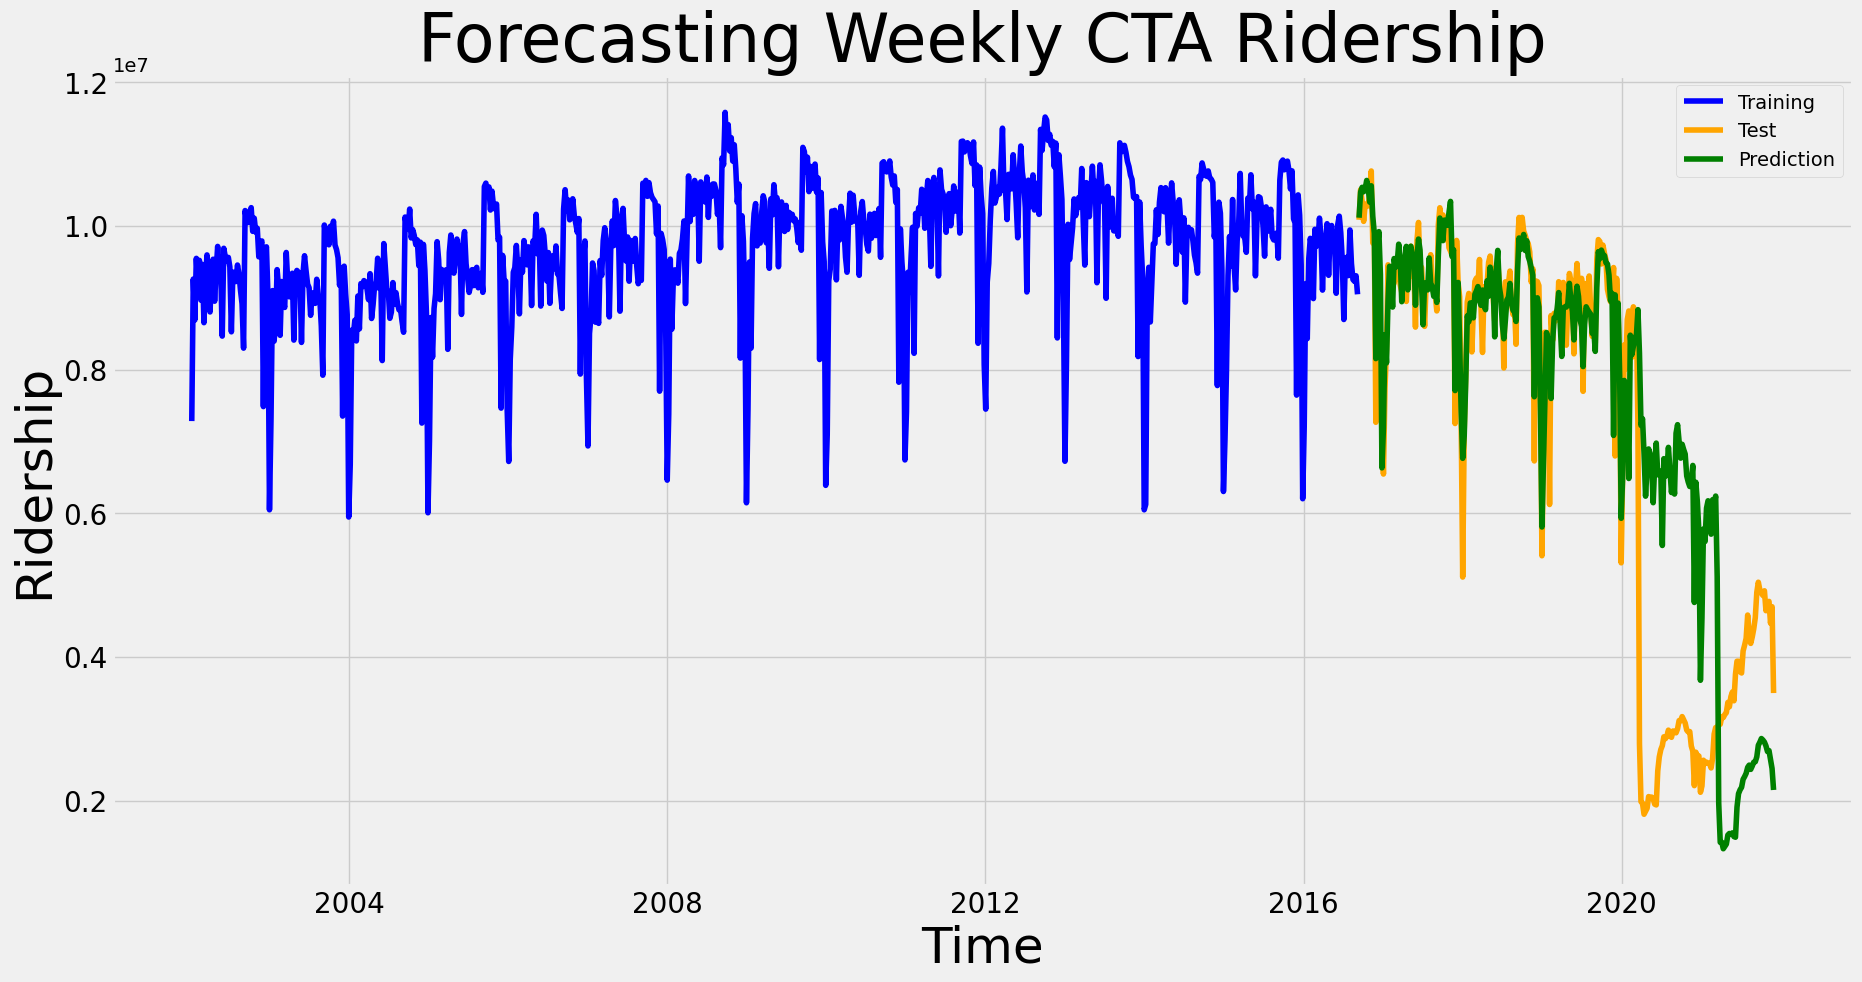

In [278]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction')
# Set label.
plt.title(label = 'Forecasting Weekly CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();

#plt.savefig('../capstone-data/imgs/Linear-annual-lag-weekly.png')

Does a decent job of handling the data until the covid drop off, not very effecitve with sudden shocks.

In [279]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_52'}),
                                                 rides['total_rides'],
                                                 test_size=.25,
                                                 shuffle=False)

In [280]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_2,lag_3,lag_4,lag_12,lag_26,time
date,,,,,,,,
2001-01-08,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-15,1.0,8466849.0,NaN,NaN,NaN,NaN,NaN,1
2001-01-22,1.0,8890293.0,8466849.0,NaN,NaN,NaN,NaN,2
2001-01-29,1.0,9406570.0,8890293.0,8466849.0,NaN,NaN,NaN,3
2001-02-05,1.0,9348079.0,9406570.0,8890293.0,8466849.0,NaN,NaN,4


In [281]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     87.32
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           8.74e-94
Time:                        23:46:48   Log-Likelihood:                -11773.
No. Observations:                 792   AIC:                         2.356e+04
Df Residuals:                     784   BIC:                         2.360e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.47e+06   5.21e+05      2.819      0.005    4.46e+05    2.49e+06
lag_1          0.4674      0.035     13.414      0.000       0.399       0.536
lag_2          0.0683      0.039      1.772      0.077      -0.007       0.144
lag_3         -0.0364      0.039     -0.945      0.345      -0.112       0.039
lag_4          0.1809      0.035      5.209      0.000       0.113       0.249
lag_12         0.0127      0.029      0.435      0.664      -0.045       0.070
lag_26         0.1475      0.029      5.078      0.000       0.090       0.205
time         190.4632    134.394      1.417      0.157     -73.352     454.278
==============================================================================
Omnibus:                      309.726   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1363.441
Skew:                          -1.781   Prob(JB):                    8.56e-297
Kurtosis:                       8.350   Cond. No.                     5.03e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [282]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.8404177511772376

In [283]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

1141954.783696653

In [284]:
lm_results.aic

23562.97313286574

Initial and basic testing shows we are off by around 1,168,664 riders per day with an AIC of 25,224.

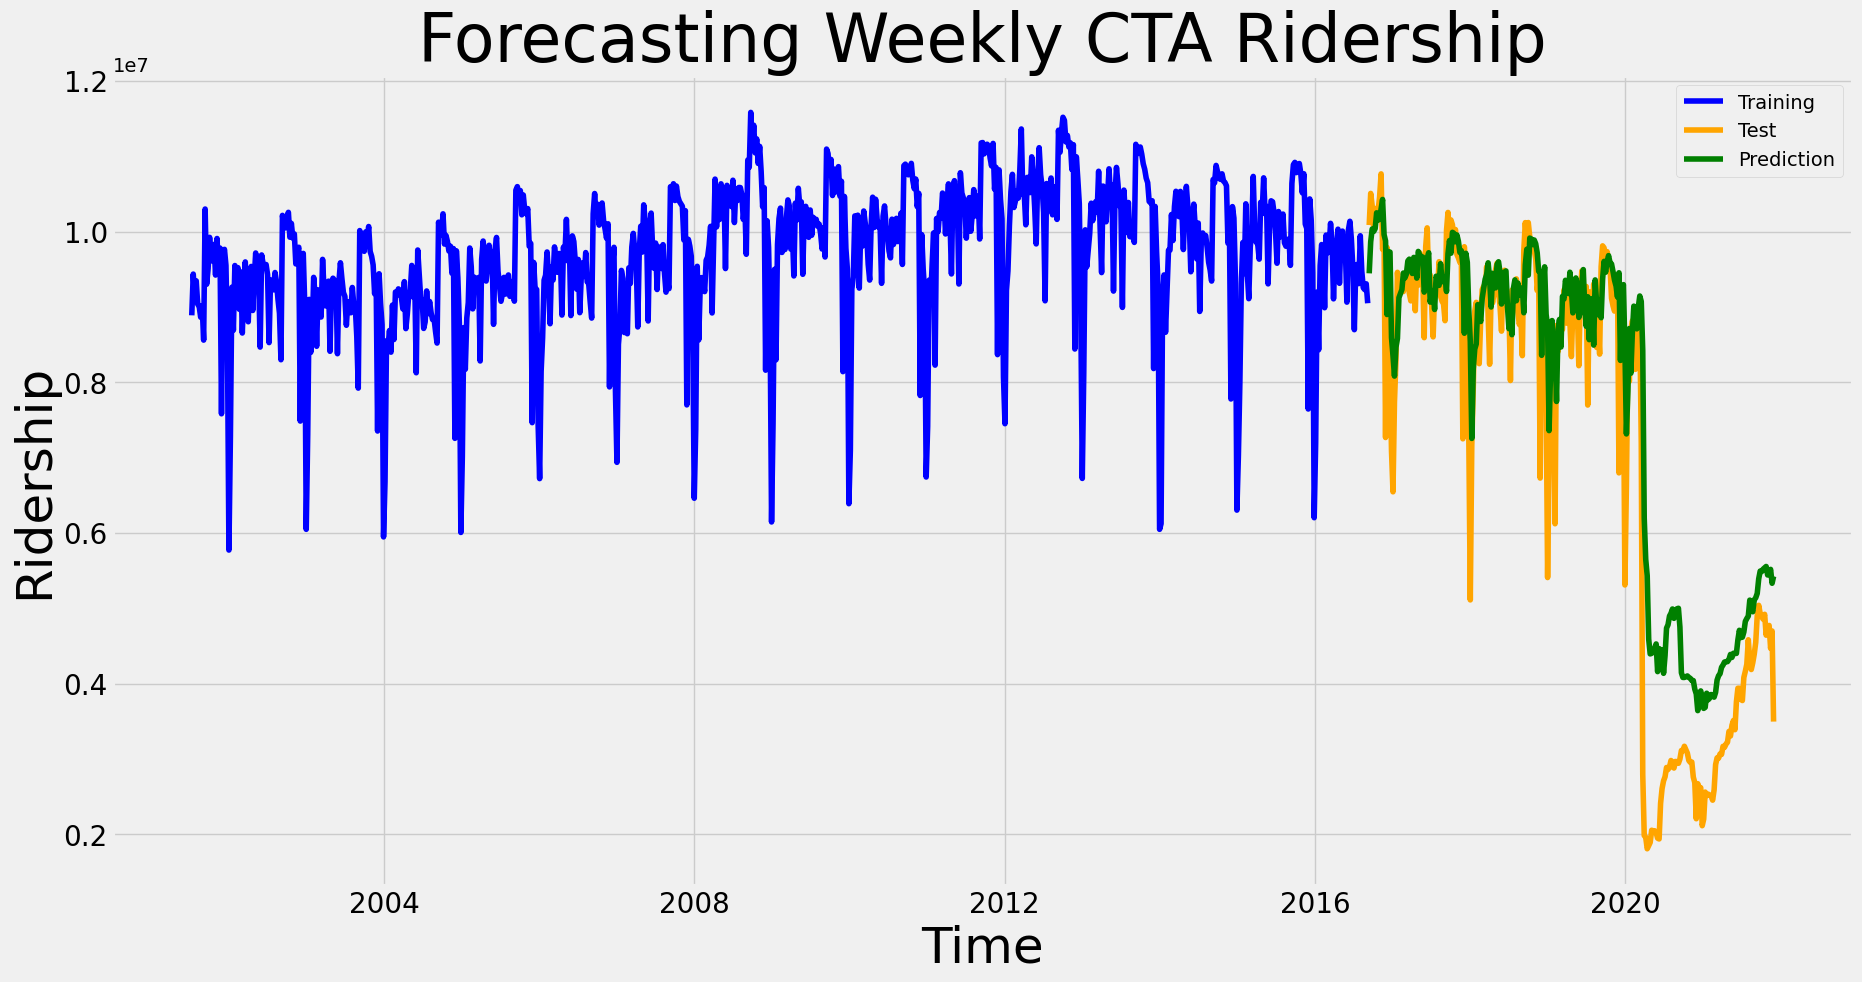

In [285]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction')
# Set label.
plt.title(label = 'Forecasting Weekly CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();
#plt.savefig('../capstone-data/imgs/Linear-no-annual-weekly.png')

Removing the yearly lag seems to make the RMSE and AIC worse, but it handles the shock more elegantly.

## ARIMA

#### Finding '*d*'

In [286]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [287]:
rides['rides_first_diff'] = rides['total_rides'].diff(1)
rides['rides_second_diff'] = rides['total_rides'].diff(1).diff(1)

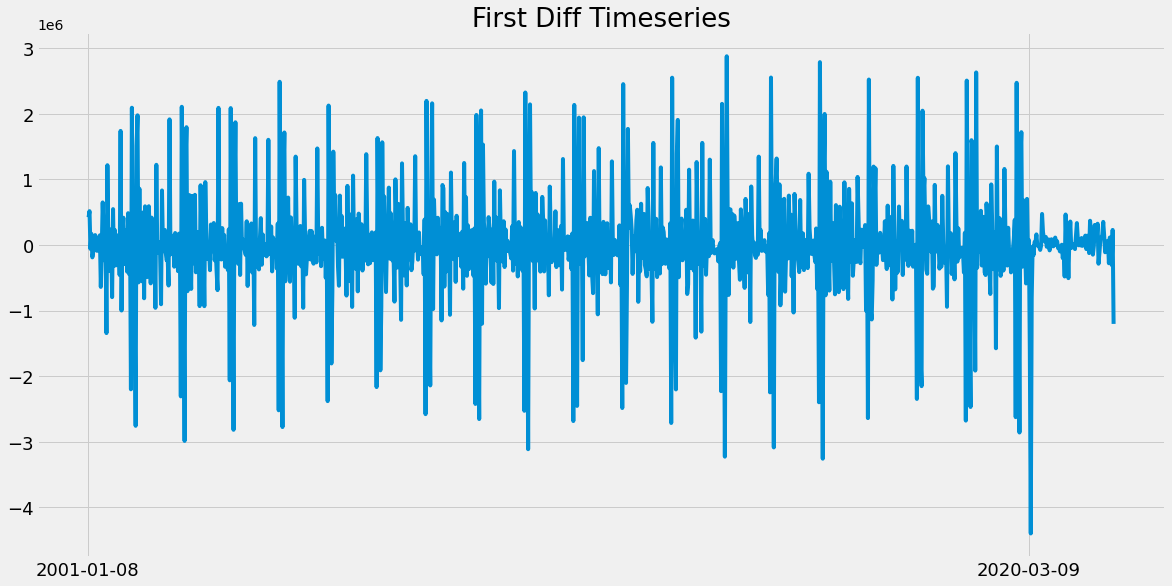

In [25]:
plot_series(rides,['rides_first_diff'], title = 'First Diff Timeseries', steps=1000)

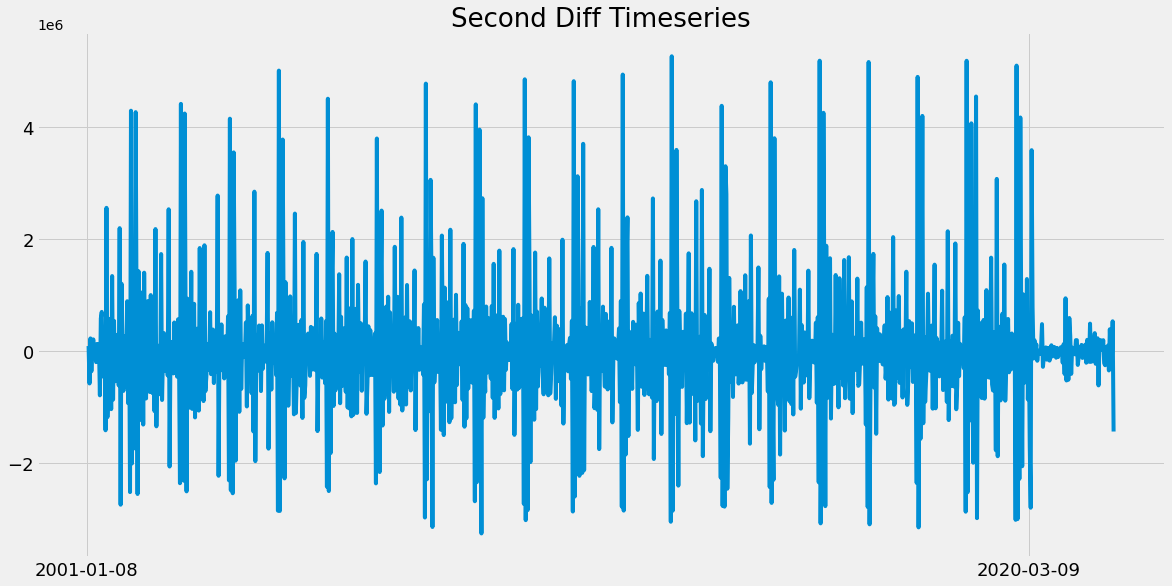

In [26]:
plot_series(rides,['rides_second_diff'], title = 'Second Diff Timeseries', steps=1000)

In [288]:
# Code written by Joseph Nelson
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index = ['Test Statsitic','p-value'])
    return dfoutput

In [28]:
print(f'Orig: \n{interpret_dftest(adfuller(rides["total_rides"]))}\n\nFirst Diff: \n{interpret_dftest(adfuller(rides["rides_first_diff"].dropna()))}')



Orig: 
Test Statsitic   -1.233440
p-value           0.659048
dtype: float64

First Diff: 
Test Statsitic   -8.635453e+00
p-value           5.606887e-14
dtype: float64


Since in the original data the p-value is not less than 0.05 we cannot reject Null Hypothesis; however, our first order difference is low enough to continue with '*d = 1*.'

#### Finding '*p*' & '*q*'

#### ARIMA

In [289]:
y_train, y_test = train_test_split(rides['rides_first_diff'].dropna(), test_size=.25,shuffle=False)

In [48]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(25):
    for q in range(25):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order = (p, 1, q)) 
            
            model = arima.fit()

            if model.aic < best_aic:
                
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('Model Completed.')
print(f'Best ARIMA: ({best_p},1,{best_q}).')
print(f'AIC: {best_aic}.')



Model Completed.
Best ARIMA: (23,1,18).
AIC: 24116.002285979695.


In [290]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), 
             order = (23,1,18)) # Endog = Y variable 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = arima.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])


In [43]:
print(f'AIC: {arima.aic}, RMSE: {metrics.mean_squared_error(y_test,preds,squared=False)}, STD: {rides["total_rides"].std()}')

AIC: 24116.002285979695, RMSE: 736057.2987961393, STD: 1984779.622351952


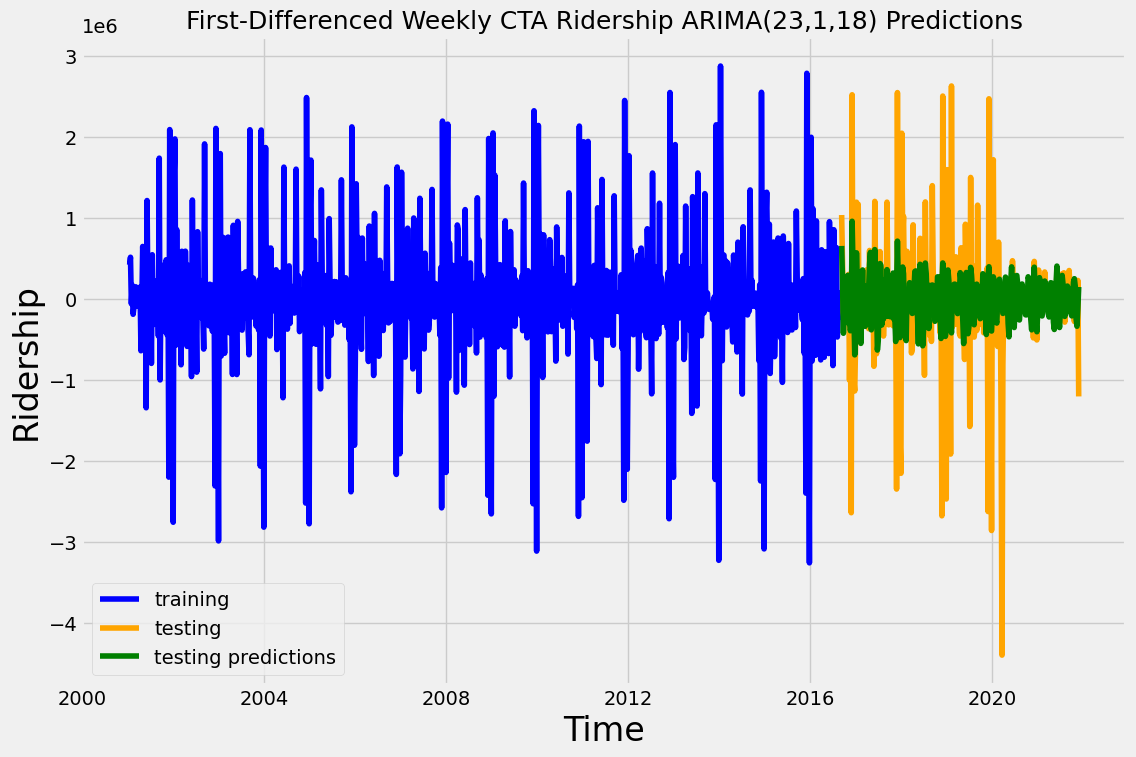

In [291]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')
plt.plot(y_test, color = 'orange', label = 'testing')
plt.plot(preds, color = 'green', label ='testing predictions')
plt.title('First-Differenced Weekly CTA Ridership ARIMA(23,1,18) Predictions',fontsize=18)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership', size=24)
plt.legend();
#plt.savefig('../capstone-data/imgs/ARIMA(23,1,18).png')


The full ARIMA model seems to adjust well to sudden shocks but the predictions aren't that accurate.

In [33]:
y_train.index.duplicated().sum()

0

#### Auto-ARIMA w/o Seasonality

In [54]:
y_train, y_test = train_test_split(rides['rides_first_diff'].dropna(), test_size=.25,shuffle=False)

In [60]:
arima_model = auto_arima(y_train,start_p=0,d=1,start_q=0,
                        max_p=20,max_d=1,max_q=20,seasonal=True,error_action='warn',
                         trace=2,supress_warnings='True',
                        stepwise=True,random_state=42,n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25300.879, Time=0.03 sec
First viable model found (25300.879)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24962.732, Time=0.05 sec
New best model found (24962.732 < 25300.879)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24564.938, Time=0.07 sec
New best model found (24564.938 < 24962.732)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25298.880, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24506.126, Time=0.12 sec
New best model found (24506.126 < 24564.938)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24480.282, Time=0.20 sec
New best model found (24480.282 < 24506.126)
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24862.335, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24434.206, Time=0.19 sec
New best model found (24434.206 < 24480.282)
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24711.289, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24391.897, Time=0.32 sec
New best model found (243

In [61]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  817
Model:               SARIMAX(8, 1, 2)   Log Likelihood              -12169.058
Date:                Sun, 06 Feb 2022   AIC                          24362.116
Time:                        15:05:48   BIC                          24418.569
Sample:                             0   HQIC                         24383.783
                                - 817                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1277.6686   2196.293     -0.582      0.561   -5582.323    3026.986
ar.L1         -1.4123      0.047    -30.020      0.000      -1.505      -1.320
ar.L2         -0.7584      0.071    -10.629      0.000      -0.898      -0.619
ar.L3         -0.6584      0.083     -7.903      0.000      -0.822      -0.495
ar.L4         -0.4338      0.101     -4.304      0.000      -0.631      -0.236
ar.L5         -0.0895      0.104     -0.862      0.388      -0.293       0.114
ar.L6         -0.0222      0.099     -0.225      0.822      -0.216       0.172
ar.L7         -0.0030      0.093     -0.032      0.974      -0.186       0.179
ar.L8          0.0432      0.056      0.766      0.444      -0.067       0.154
ma.L1         -0.0142      0.034     -0.422      0.673      -0.080       0.052
ma.L2         -0.9650      0.032    -30.180      0.000      -1.028      -0.902
sigma2      5.936e+11   5.55e-05   1.07e+16      0.000    5.94e+11    5.94e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               875.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -1.32
Prob(H) (two-sided):                  0.18   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+31. Standard errors may be unstable.
"""

In [62]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(y_test.index)),index=y_test.index)
prediction.columns = ['pred_ridership']
prediction

,pred_ridership
date,
2016-09-12,3195.382212
2016-09-19,15487.066421
2016-09-26,-6111.598200
2016-10-03,-74585.715525
2016-10-10,-46406.166449
...,...
2021-11-01,-112964.941955
2021-11-08,-116171.855392
2021-11-15,-113582.505171


In [63]:
arima_model.aic()

24362.116394596156

In [64]:
metrics.mean_squared_error(y_test,prediction,squared=False)

780236.6963644671

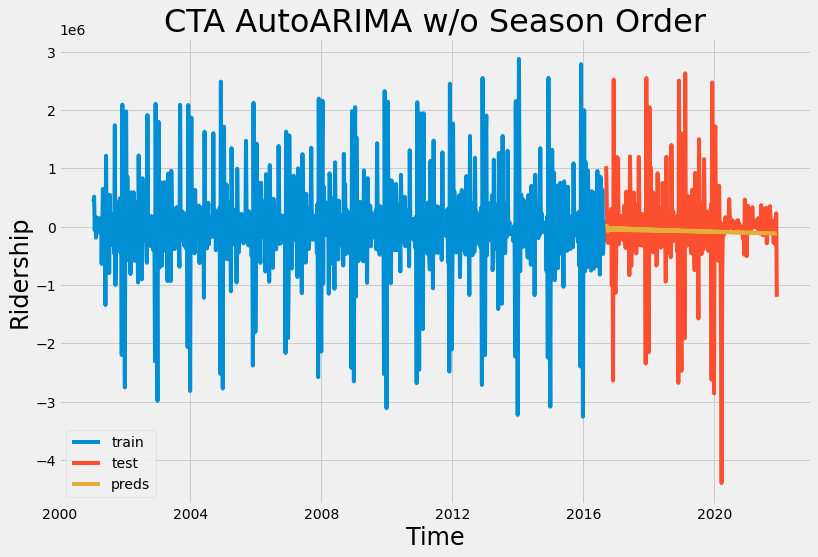

In [65]:
plt.figure(figsize=(12,8))
plt.plot(y_train,label='train')
plt.plot(y_test,label='test')
plt.plot(prediction,label = 'preds')
plt.title('CTA AutoARIMA w/o Season Order',size=32)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend(loc = 'lower left')
#plt.savefig('./imgs/ARIMA(6,1,2)(5,0,3)[7].png')

### SARIMAX

In [31]:
model = SARIMAX(y_train.astype(float).dropna(), order=(8,1,2), seasonal_order=(6,1,2,52))
sari = model.fit()

In [55]:
preds_train = sari.predict(start = y_train.index[1], end = y_train.index[-1])
preds = sari.predict(start = y_test.index[0], end = y_test.index[-1])


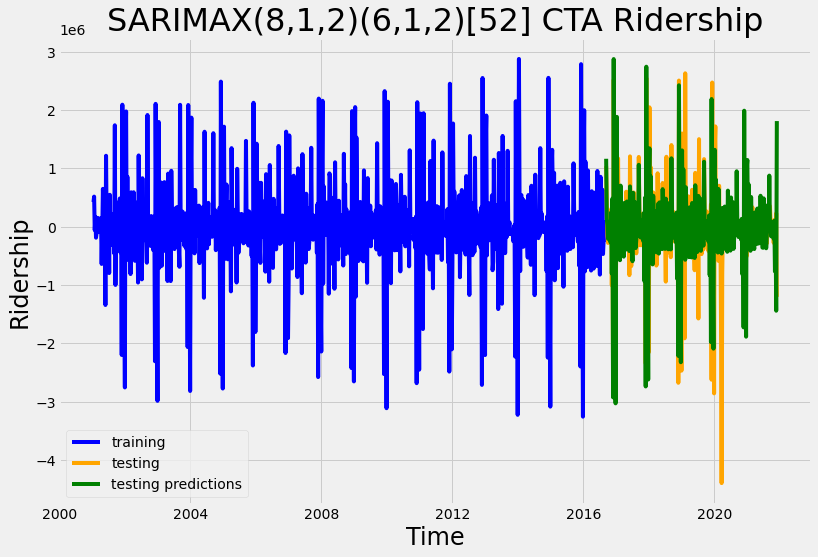

In [37]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')

plt.plot(y_test, color = 'orange', label = 'testing')

plt.plot(preds, color = 'green', label ='testing predictions')
plt.title('SARIMAX(8,1,2)(6,1,2)[52] CTA Ridership', size=32)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership', size=24)

plt.legend();
#plt.savefig('../capstone-data/imgs/SARIMA(8,1,2)(6,1,2)[52].png')

In [56]:
print(f'SARIMAX: {sari.aic}')

SARIMAX: 22086.11042073979


In [244]:
metrics.mean_squared_error(y_test,preds,squared=False)

674141.5125795112

In [245]:
739716413073.0125 **.5

860067.6793561147

# VAR

In [59]:
mv = df[['total_rides','20_yr','gas_price','tmin','StringencyLegacyIndex','C6_Stay at home requirements','total_daily_doses','damage_indicator','ConfirmedDeaths']].copy()

In [60]:
mv

,total_rides,20_yr,gas_price,tmin,StringencyLegacyIndex,C6_Stay at home requirements,total_daily_doses,damage_indicator,ConfirmedDeaths
date,,,,,,,,,
2001-01-08,8466849.0,5.522857,1.477,17.285714,0.00,0.0,0.000000,0.000000,0.0
2001-01-15,8890293.0,5.680000,1.569,26.142857,0.00,0.0,0.000000,0.000000,0.0
2001-01-22,9406570.0,5.662857,1.546,17.714286,0.00,0.0,0.000000,0.000000,0.0
2001-01-29,9348079.0,5.757143,1.541,20.285714,0.00,0.0,0.000000,0.000000,0.0
2001-02-05,9518605.0,5.608571,1.501,19.857143,0.00,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
2021-11-01,4758539.0,1.984286,3.539,42.571429,34.52,0.0,9686.571429,2.557916,197316.0
2021-11-08,4772989.0,1.927143,3.616,35.714286,33.50,0.0,11094.714286,2.579138,198543.0
2021-11-15,4468877.0,1.971429,3.557,36.142857,27.38,0.0,13830.428571,2.590238,199443.0


In [62]:
print(f'total_rides 1 diff: \n{interpret_dftest(adfuller(mv["total_rides"].diff(1).dropna()))}')
print()
print(f'20_yr 1 diff: \n{interpret_dftest(adfuller(mv["20_yr"].diff(1).dropna()))}')
print()

print(f'gas_price NO diff: \n{interpret_dftest(adfuller(mv["gas_price"].dropna()))}')
print()

print(f'tmin NO diff: \n{interpret_dftest(adfuller(mv["tmin"]))}')
print()

print(f'StringencyLegacyIndex 1 diff: \n{interpret_dftest(adfuller(mv["StringencyLegacyIndex"].diff(1).dropna()))}')
print()

print(f'C6_Stay at home requirements NO diff: \n{interpret_dftest(adfuller(mv["C6_Stay at home requirements"].dropna()))}')
print()

print(f'total_daily_doses 1 diff: \n{interpret_dftest(adfuller(mv["total_daily_doses"].dropna()))}')
print()

print(f'damage_indicator 1 diff: \n{interpret_dftest(adfuller(mv["damage_indicator"].diff(1).dropna()))}')
print()

print(f'ConfirmedDeaths 1 diff: \n{interpret_dftest(adfuller(mv["ConfirmedDeaths"].diff(1).dropna()))}')

total_rides 1 diff: 
Test Statsitic   -8.635453e+00
p-value           5.606887e-14
dtype: float64

20_yr 1 diff: 
Test Statsitic   -1.430881e+01
p-value           1.194009e-26
dtype: float64

gas_price NO diff: 
Test Statsitic   -2.976228
p-value           0.037175
dtype: float64

tmin NO diff: 
Test Statsitic   -1.477799e+01
p-value           2.268479e-27
dtype: float64

StringencyLegacyIndex 1 diff: 
Test Statsitic   -9.754737e+00
p-value           7.844241e-17
dtype: float64

C6_Stay at home requirements NO diff: 
Test Statsitic   -3.157975
p-value           0.022550
dtype: float64

total_daily_doses 1 diff: 
Test Statsitic   -2.917025
p-value           0.043404
dtype: float64

damage_indicator 1 diff: 
Test Statsitic   -6.345571e+00
p-value           2.688256e-08
dtype: float64

ConfirmedDeaths 1 diff: 
Test Statsitic   -2.956206
p-value           0.039192
dtype: float64


Making sure data is stationary with a threshold of <.05 to allow of rrejection of the null hypothesis.

In [63]:
mv['total_rides_diff'] = mv['total_rides'].diff(1)
mv['20_yr_diff'] = mv['20_yr'].diff(1)
#mv['gas_close_diff'] = mv['gas_close'].diff(1)
mv['Stringency_diff'] = mv['StringencyLegacyIndex'].diff(1)
mv['total_daily_doses_diff'] = mv['total_daily_doses'].diff(1)
mv['damage_indicator_diff'] = mv['damage_indicator'].diff(1)
mv['ConfirmedDeaths_diff'] = mv['ConfirmedDeaths'].diff(1)

In [78]:
mv2 = mv[['total_rides_diff','20_yr_diff','damage_indicator_diff','tmin','gas_price']]

In [79]:
train,test = train_test_split(mv2.dropna(),test_size=.25,shuffle=False,random_state=42)

In [80]:
train

,total_rides_diff,20_yr_diff,damage_indicator_diff,tmin,gas_price
date,,,,,
2001-01-15,423444.0,0.157143,0.000000,26.142857,1.569
2001-01-22,516277.0,-0.017143,0.000000,17.714286,1.546
2001-01-29,-58491.0,0.094286,0.000000,20.285714,1.541
2001-02-05,170526.0,-0.148571,0.000000,19.857143,1.501
2001-02-12,-187836.0,-0.024286,0.000000,22.142857,1.525
...,...,...,...,...,...
2016-08-08,-468249.0,0.071429,0.030205,71.857143,2.317
2016-08-15,-222021.0,-0.030000,-0.001833,73.285714,2.257
2016-08-22,-25111.0,0.050000,0.020891,67.428571,2.356


In [81]:
model = VAR(train)

In [84]:
ts_model = model.fit(maxlags = 12, ic = 'bic')

In [85]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Feb, 2022
Time:                     20:07:33
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    16.7359
Nobs:                     815.000    HQIC:                   16.5403
Log likelihood:          -12417.7    FPE:                1.35036e+07
AIC:                      16.4185    Det(Omega_mle):     1.26281e+07
--------------------------------------------------------------------
Results for equation total_rides_diff
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                       -27965.397897     99994.813026           -0.280           0.780
L1.total_rides_diff             -0.359702         0.034612          -10.393           0.000
L1.20

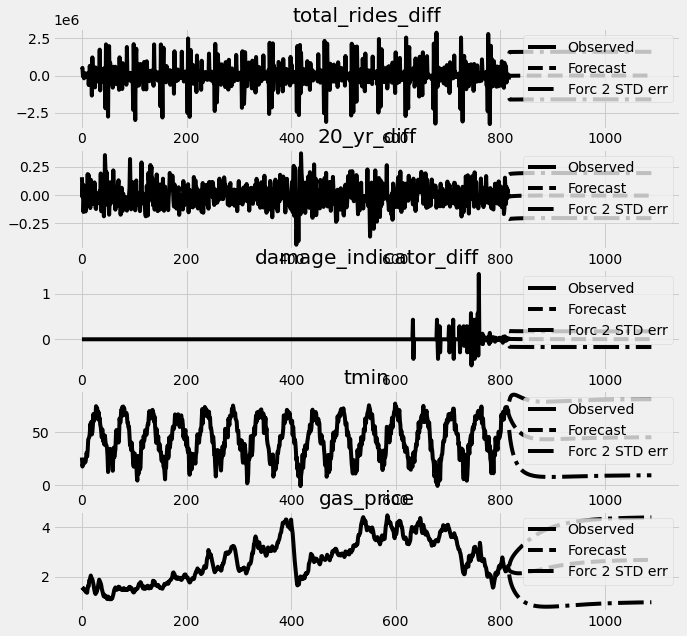

In [87]:
ts_model.plot_forecast(len(test));


In [88]:
ts_model.aic

16.418460655732485

In [89]:
# Let's use MSE to evaluate our models.

# Save our forecast as forecast.
forecast = ts_model.forecast(train.values, len(test))

# Instantiate MSE values at 0.
mse_riders = 0
mse_20_yr = 0
mse_damage = 0
mse_tmin = 0


# Loop through each forecasted time point.
for time in range(len(test)):
    
    # Calculate (expected - observed) ** 2 and add to MSE.
    mse_riders += (forecast[time][0] - test.values[time][0]) ** 2
    mse_20_yr += (forecast[time][1] - test.values[time][1]) ** 2
    mse_damage += (forecast[time][2] - test.values[time][2]) ** 2
    mse_tmin += (forecast[time][3] - test.values[time][3]) ** 2

# Divide SSE to get MSE.
mse_riders /= len(test)
mse_20_yr /= len(test)
mse_damage /= len(test)
mse_tmin /= len(test)

# Generate output.    
print(f'The test RMSE on the Ridership data is: {round(mse_riders**.5, 4)}')
print(f'The test RMSE on the 20_yr data is: {round(mse_20_yr**.5, 4)}')
print(f'The test RMSE on the damage data is: {round(mse_damage**.5, 4)}')
print(f'The test RMSE on the tmin data is: {round(mse_tmin**.5, 4)}')

The test RMSE on the Ridership data is: 780051.8439
The test RMSE on the 20_yr data is: 0.081
The test RMSE on the damage data is: 0.0269
The test RMSE on the tmin data is: 18.4079


# Prophet

In [313]:
#df = pd.read_csv('../capstone-data/daily-merged.csv')
df = pd.read_csv('../capstone-data/weekly-merged.csv')

In [314]:
df['date'] = pd.to_datetime(df['date'])
df = df.drop(df.tail(1).index)
df = df.drop(df.head(1).index)

In [315]:
df.rename(columns={'date':'ds','total_rides':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df[['ds','y']]


In [316]:
# def is_covid(ds):
#     date = pd.to_datetime(ds)
#     return (date.year < 2019 or date.year > 2020) #or (date.year == 2020 and date.month <= 4))

# df['on_season'] = df['ds'].apply(is_covid)
# df['off_season'] = ~df['ds'].apply(is_covid)


In [317]:
y_train, y_test = train_test_split(df,test_size=.05, shuffle=False,random_state=42)

In [318]:
m = Prophet()
m.fit(y_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


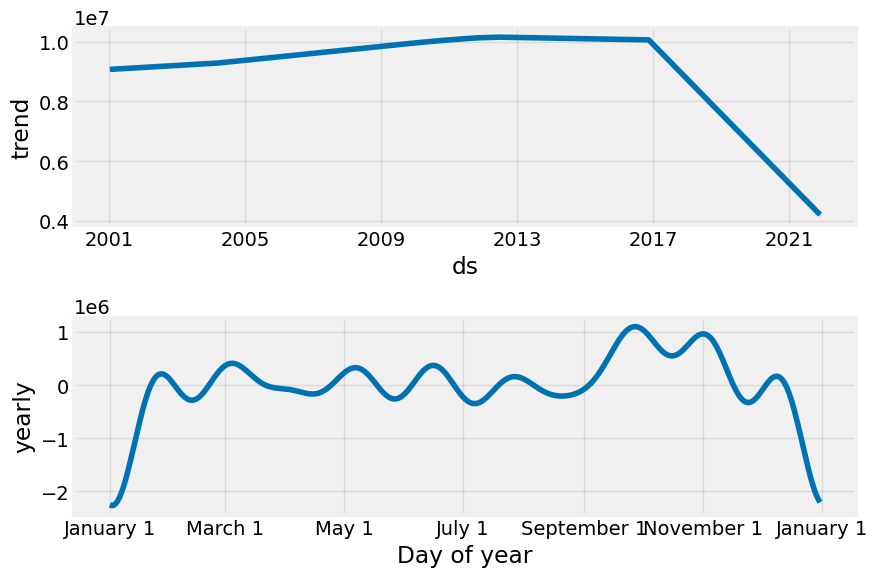

In [320]:
future = m.make_future_dataframe(periods=len(y_test),freq='W')
forecast = m.predict(future)
fig = m.plot_components(forecast)
#plt.savefig('../capstone-data/imgs/Prophetweeklycomp.png')

In [321]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1086,2021-10-31,5.255408e+06,3.979899e+06,6.499986e+06
1087,2021-11-07,5.061019e+06,3.802880e+06,6.256377e+06
1088,2021-11-14,4.472450e+06,3.183938e+06,5.631031e+06
1089,2021-11-21,3.962608e+06,2.659831e+06,5.144500e+06
1090,2021-11-28,3.953340e+06,2.687815e+06,5.233320e+06


In [322]:
y_test.head()

,ds,y
1037,2020-11-16,2760539.0
1038,2020-11-23,2687581.0
1039,2020-11-30,2208175.0
1040,2020-12-07,2673441.0
1041,2020-12-14,2617080.0


In [323]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-08,9.071681e+06,5.856547e+06,8.375462e+06,9.071681e+06,9.071681e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,0.0,0.0,0.0,7.155780e+06
1,2001-01-15,9.072946e+06,7.001497e+06,9.385103e+06,9.072946e+06,9.072946e+06,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,0.0,0.0,0.0,8.185403e+06
2,2001-01-22,9.074210e+06,7.906404e+06,1.034006e+07,9.074210e+06,9.074210e+06,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,0.0,0.0,0.0,9.070703e+06
3,2001-01-29,9.075474e+06,7.954555e+06,1.046827e+07,9.075474e+06,9.075474e+06,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,0.0,0.0,0.0,9.271745e+06
4,2001-02-05,9.076738e+06,7.866696e+06,1.026638e+07,9.076738e+06,9.076738e+06,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,0.0,0.0,0.0,8.985701e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2021-10-31,4.296214e+06,3.979899e+06,6.499986e+06,4.253252e+06,4.339866e+06,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,0.0,0.0,0.0,5.255408e+06
1087,2021-11-07,4.273946e+06,3.802880e+06,6.256377e+06,4.229824e+06,4.318716e+06,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,0.0,0.0,0.0,5.061019e+06
1088,2021-11-14,4.251677e+06,3.183938e+06,5.631031e+06,4.206295e+06,4.298289e+06,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,0.0,0.0,0.0,4.472450e+06
1089,2021-11-21,4.229409e+06,2.659831e+06,5.144500e+06,4.181801e+06,4.277927e+06,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,0.0,0.0,0.0,3.962608e+06


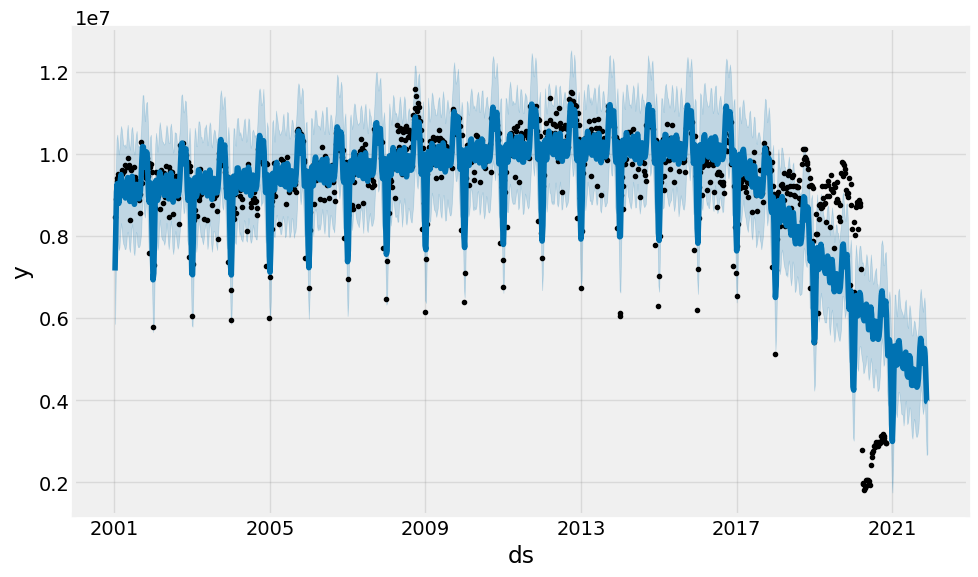

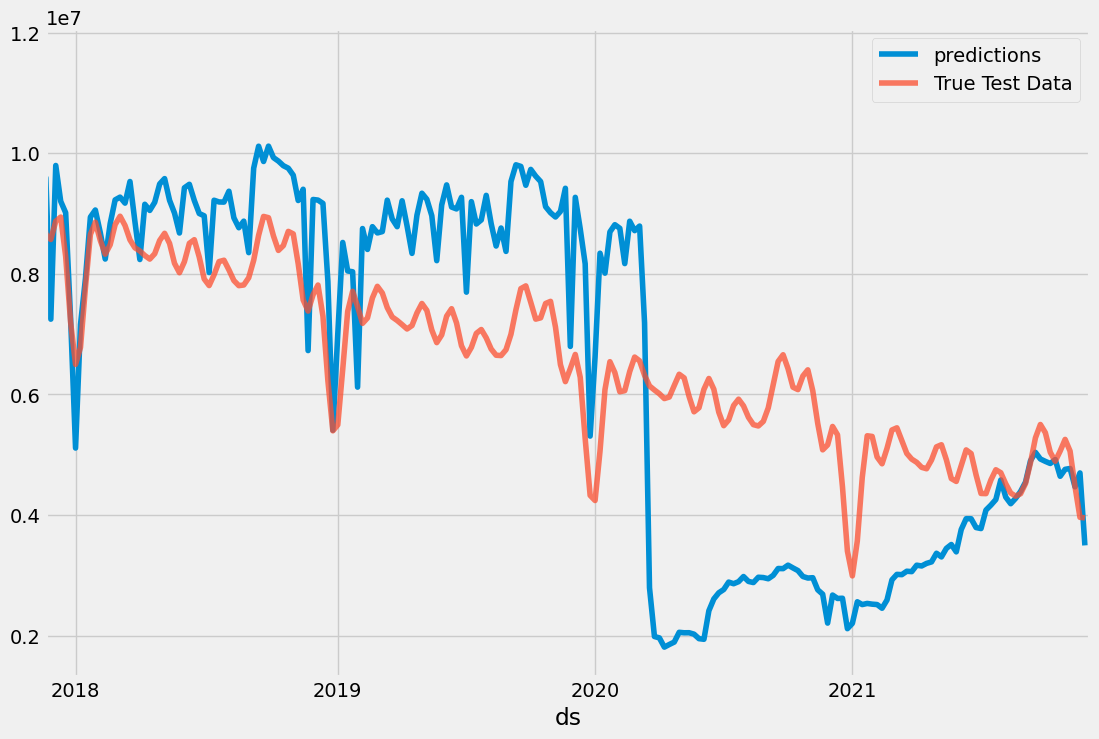

In [324]:
m.plot(forecast)
ax1=df.plot(x='ds',y='y',legend=True,label='predictions',figsize=(12,8),)
#plt.savefig('../capstone-data/imgs/Prophetpredsweekly1.png')
forecast.plot(x='ds',y='yhat',legend=True,label='True Test Data',ax=ax1,
              xlim=('2017-11-14','2021-11-30'),alpha=.75);
#plt.savefig('../capstone-data/imgs/Prophetpredsweekly2.png')

In [325]:
fig =plot_plotly(m, forecast)

#fig.write_html("../capstone-data/imgs/interactive2.html")

In [326]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-08,9.071681e+06,5.856547e+06,8.375462e+06,9.071681e+06,9.071681e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,-1.915901e+06,0.0,0.0,0.0,7.155780e+06
1,2001-01-15,9.072946e+06,7.001497e+06,9.385103e+06,9.072946e+06,9.072946e+06,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,-8.875425e+05,0.0,0.0,0.0,8.185403e+06
2,2001-01-22,9.074210e+06,7.906404e+06,1.034006e+07,9.074210e+06,9.074210e+06,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,-3.506066e+03,0.0,0.0,0.0,9.070703e+06
3,2001-01-29,9.075474e+06,7.954555e+06,1.046827e+07,9.075474e+06,9.075474e+06,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,1.962717e+05,0.0,0.0,0.0,9.271745e+06
4,2001-02-05,9.076738e+06,7.866696e+06,1.026638e+07,9.076738e+06,9.076738e+06,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,-9.103631e+04,0.0,0.0,0.0,8.985701e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2021-10-31,4.296214e+06,3.979899e+06,6.499986e+06,4.253252e+06,4.339866e+06,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,9.591941e+05,0.0,0.0,0.0,5.255408e+06
1087,2021-11-07,4.273946e+06,3.802880e+06,6.256377e+06,4.229824e+06,4.318716e+06,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,7.870737e+05,0.0,0.0,0.0,5.061019e+06
1088,2021-11-14,4.251677e+06,3.183938e+06,5.631031e+06,4.206295e+06,4.298289e+06,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,2.207731e+05,0.0,0.0,0.0,4.472450e+06
1089,2021-11-21,4.229409e+06,2.659831e+06,5.144500e+06,4.181801e+06,4.277927e+06,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,-2.668006e+05,0.0,0.0,0.0,3.962608e+06


In [327]:
forecast['ds']=pd.to_datetime(forecast['ds'])
forecast.set_index('ds',inplace=True)

y_train['ds']=pd.to_datetime(y_train['ds'])
y_train.set_index('ds',inplace=True)

y_test['ds']=pd.to_datetime(y_test['ds'])
y_test.set_index('ds',inplace=True)

In [328]:
y_test.head()

,y
ds,
2020-11-16,2760539.0
2020-11-23,2687581.0
2020-11-30,2208175.0
2020-12-07,2673441.0
2020-12-14,2617080.0


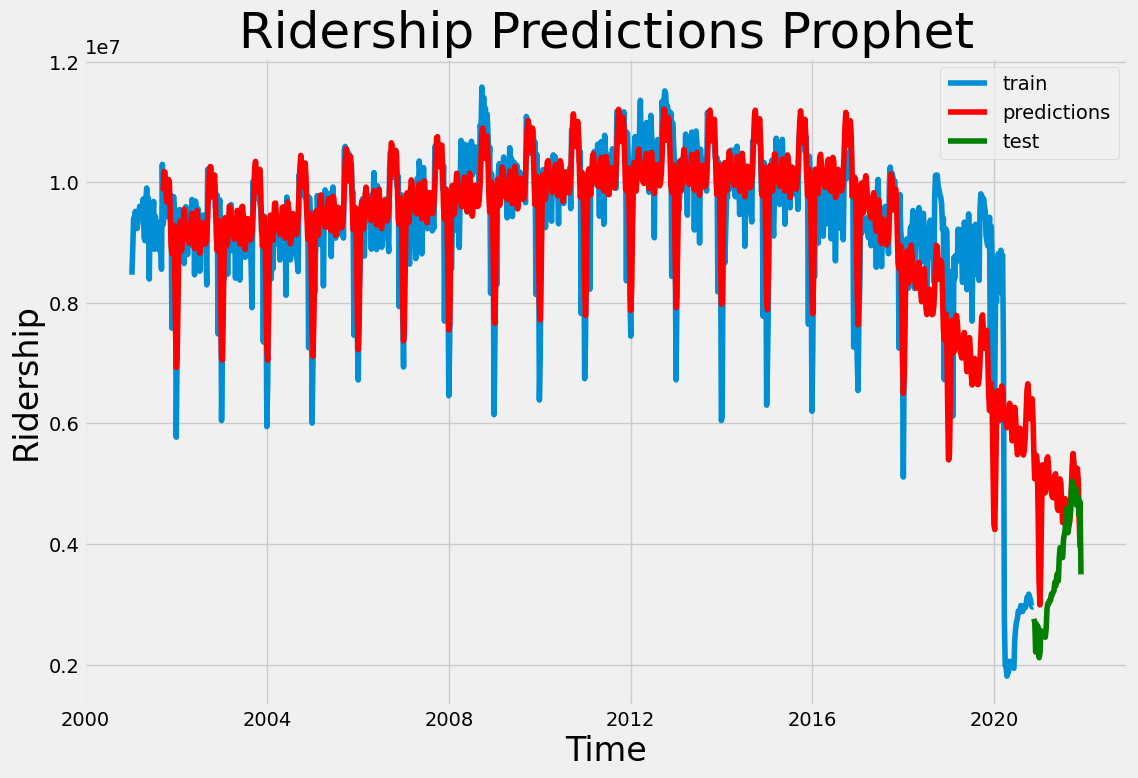

In [330]:
plt.figure(figsize=(12,8))
plt.plot(y_train['y'], label = 'train' )
plt.plot(forecast[['yhat']].tail(len(y_test)+1000),color='r', label ='predictions')
plt.plot(y_test['y'], label='test',color='green')
plt.title('Ridership Predictions Prophet', size=36)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend();
#plt.savefig('../capstone-data/imgs/Prophetpredsweekly3.png')

In [331]:
forecast[['yhat']]

,yhat
ds,
2001-01-08,7.155780e+06
2001-01-15,8.185403e+06
2001-01-22,9.070703e+06
2001-01-29,9.271745e+06
2001-02-05,8.985701e+06
...,...
2021-10-31,5.255408e+06
2021-11-07,5.061019e+06
2021-11-14,4.472450e+06


In [332]:
pro_preds = forecast[['yhat']].tail(len(y_test))
metrics.mean_squared_error(y_test[['y']], pro_preds,squared=False)

1570733.3868240423

In [312]:
initial= '5000 days'
period= '365 days'
horizon = 365/2
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,horizon)
# Performance Metrics of fb_cv
performance_metrics(fb_cv,rolling_window=.01)

INFO:fbprophet:Making 72 forecasts with cutoffs between 2002-08-14 18:00:00 and 2020-05-10 12:00:00


  0%|          | 0/72 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 18:00:00,2.208921e+12,1.486244e+06,585472.686454,0.192795,0.020784,0.888889
1,2 days 00:00:00,1.052065e+11,3.243556e+05,258454.753763,0.027252,0.019183,0.944444
2,2 days 06:00:00,8.603273e+10,2.933134e+05,227676.238359,0.023883,0.019183,0.944444
3,2 days 12:00:00,8.345919e+10,2.888930e+05,216901.697715,0.022743,0.015337,0.944444
4,2 days 18:00:00,1.212129e+11,3.481564e+05,271677.001463,0.028671,0.019184,0.888889
...,...,...,...,...,...,...,...
719,181 days 12:00:00,1.438236e+11,3.792408e+05,296483.876557,0.028668,0.020078,0.888889
720,181 days 18:00:00,1.442012e+11,3.797384e+05,297557.371923,0.028960,0.020078,0.888889
721,182 days 00:00:00,1.553322e+11,3.941221e+05,316873.886579,0.030746,0.022161,0.888889
722,182 days 06:00:00,1.736563e+11,4.167209e+05,336606.792649,0.033414,0.027431,0.833333


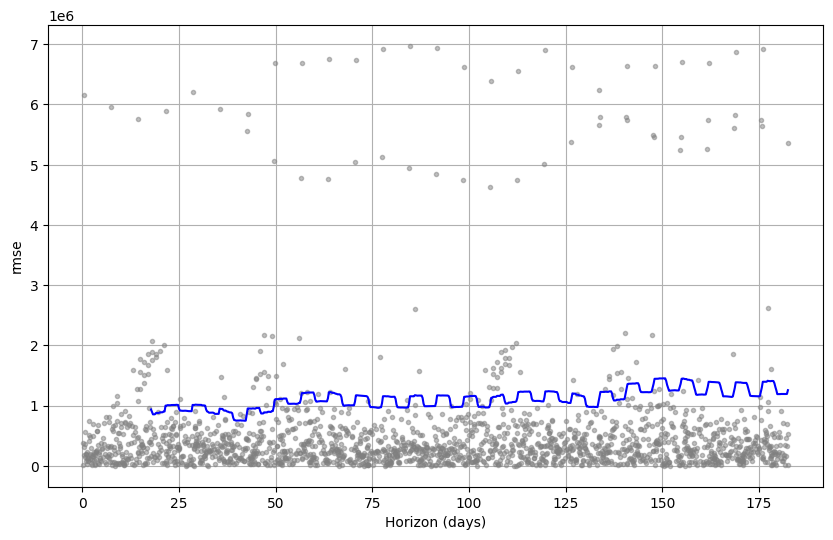

In [154]:
plot_cross_validation_metric(fb_cv,'rmse');

# Linear Regression

In [257]:
#df = pd.read_csv('../capstone-data/daily-merged.csv')
df = pd.read_csv('../capstone-data/weekly-merged.csv')

In [258]:
df

,date,bus,rail_boardings,total_rides,prcp,tmax,tmin,gas_open,gas_close,gas_volume,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,total_daily_doses,total_daily_cum,first_dose_daily,first_dose_cum,first_dose_percent_pop,vax_series_completed_daily,vax_series_cum,vax_series_percent,crash_occurrences,damage_indicator,gas_price
0,2001-01-01,297192.0,126455.0,423647.0,0.000000,26.000000,13.000000,0.794000,0.795000,14697.000000,5.870000,5.580000,5.110000,4.870000,4.820000,4.760000,4.970000,4.920000,5.460000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.487
1,2001-01-08,5304650.0,3162199.0,8466849.0,0.000000,31.142857,17.285714,0.811429,0.817157,17527.571429,5.354286,5.170000,4.768571,4.682857,4.682857,4.735714,4.992857,4.974286,5.522857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.477
2,2001-01-15,5618534.0,3271759.0,8890293.0,0.037143,35.571429,26.142857,0.872286,0.886529,14497.714286,5.308571,5.200000,4.887143,4.824286,4.835714,4.898571,5.164286,5.174286,5.680000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.569
3,2001-01-22,5926682.0,3479888.0,9406570.0,0.000000,29.285714,17.714286,0.868500,0.875129,16529.142857,5.281429,5.155714,4.825714,4.778571,4.788571,4.851429,5.147143,5.195714,5.662857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.546
4,2001-01-29,5894412.0,3453667.0,9348079.0,0.120000,32.142857,20.285714,0.877500,0.880143,14571.857143,5.202857,5.087143,4.817143,4.788571,4.814286,4.948571,5.240000,5.301429,5.757143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2021-11-08,2760963.0,2012026.0,4772989.0,0.000000,55.142857,35.714286,2.328500,2.319557,80192.714286,0.050000,0.070000,0.148571,0.422857,0.702857,1.098571,1.361429,1.507143,1.927143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.714286,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,11979155.0,198543.0,24.205714,33.50,44.344286,45.32,37.5,11094.714286,24238965.0,2880.857143,12262639.0,0.650286,1698.714286,11295344.0,0.599000,2147.0,2.579138,3.616
1089,2021-11-15,2554455.0,1914422.0,4468877.0,0.000000,47.285714,36.142857,2.322543,2.321886,71787.000000,0.048571,0.067143,0.167143,0.507143,0.827143,1.217143,1.448571,1.564286,1.971429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0,12129124.0,199443.0,19.440000,27.38,41.670000,42.26,37.5,13830.428571,24871296.0,5320.714286,12486916.0,0.662143,1562.285714,11374567.0,0.603143,2099.0,2.590238,3.557
1090,2021-11-22,2670145.0,2028963.0,4699108.0,0.000000,48.857143,31.714286,2.297986,2.260029,45781.285714,0.050000,0.062857,0.181429,0.538571,0.870000,1.245714,1.482857,1.581429,1.998571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,

In [259]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('W-Mon')
df = df.drop(df.tail(1).index)
df = df.drop(df.head(1).index)

In [262]:
df['total_rides'].mean(), df['total_rides'].std()

(9049425.714940421, 1984779.622351952)

In [226]:
df.columns

Index(['bus', 'rail_boardings', 'total_rides', 'prcp', 'tmax', 'tmin',
       'gas_open', 'gas_close', 'gas_volume', '3_mo', '6_mo', '1_yr', '2_yr',
       '3_yr', '5_yr', '7_yr', '10_yr', '20_yr', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyLegacyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'total_daily_doses',
       'total_daily_cum', 'first_dose_daily', 'first_dose_cum',
       'first_dose_percent_pop', 'vax_

In [227]:
X=df.drop(columns={'bus','rail_boardings','total_rides','prcp', 'tmax','gas_open','gas_volume', '3_mo', '6_mo',
                  'ContainmentHealthIndex', 'EconomicSupportIndex','StringencyIndex'})
y =df['total_rides']

In [228]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42,)#shuffle=False)

In [229]:
lr = LinearRegression()

In [230]:
lr.fit(X_train,y_train)

LinearRegression()

In [231]:
lr.score(X_train,y_train),lr.score(X_test,y_test)

(0.8634540403064388, 0.843106231306217)

In [232]:
preds=lr.predict(X_test)

In [234]:
metrics.mean_squared_error(y_test,preds,squared=False)

752057.0825508571

# RandomForest

In [235]:
X=df.drop(columns={'bus','rail_boardings','total_rides', 'tmax','gas_volume', '3_mo', '6_mo',
                  'StringencyIndex'})
y =df['total_rides']

In [236]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators':range(100,1000,100),
    'max_depth': range(4,11),
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1],
}

rf_grid = GridSearchCV(rf,rf_params,cv=5,verbose=1,n_jobs=-1)

In [237]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(4, 11), 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': range(100, 1000, 100)},
             verbose=1)

In [238]:
rf_grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 800}

In [239]:
rf_grid.score(X_train,y_train),rf_grid.score(X_test,y_test)


(0.96344376717989, 0.8739316042921962)

In [240]:
preds = rf_grid.predict(X_test)

In [241]:
metrics.mean_squared_error(y_test,preds,squared=False)

674141.5125795112

# XGBoost

In [248]:
boost = xgb.XGBRegressor(booster = 'gbtree', random_seed=42)

xg_params= {
    'eta': [.1,.2,.4,.5,.8,1],
    'gamma': [0,1,2],
    'max_depth': range(1,11,1),
    'subsample':[.5,1]
}

boost_grid = GridSearchCV(boost,xg_params,n_jobs=-1,cv=5,verbose=1)

In [249]:
boost_grid.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[21:36:54] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_seed=42, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
          

In [250]:
boost_grid.best_params_

{'eta': 0.1, 'gamma': 0, 'max_depth': 6, 'subsample': 1}

In [251]:
boost_grid.score(X_train,y_train),boost_grid.score(X_test,y_test)

(0.9876198044393135, 0.87675356225871)

In [252]:
preds = boost_grid.predict(X_test)
metrics.mean_squared_error(y_test,preds,squared=False)

666553.7034638873

In [253]:
boost = xgb.XGBRegressor(booster = 'gblinear', random_seed=42)

boost.fit(X_train,y_train)

[21:38:11] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=16, num_parallel_tree=None,
             predictor=None, random_seed=42, random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [254]:
boost.score(X_train,y_train),boost.score(X_test,y_test)

(0.8422110310912052, 0.809580962185948)

In [256]:
preds= boost.predict(X_test)
metrics.mean_squared_error(y_test,preds,squared=False)

828520.2760341531

| Model                     | RMSE         | Other          |
|---------------------------|--------------|----------------|
| LinearTime w/ Annual      | 1,875,878.55 | AIC: 22,137.64 |
| LinearTime w/o Annual     | 1,141,954.78 | AIC: 23,562.97 |
| ARIMA(23,1,18)            | 736,057.29   | AIC: 24,116.00 |
| Auto-ARIMA(8,1,2)         | 780,236.69   | AIC: 24,362.11 |
| SARIMAX(8,1,2)(6,1,2)[52] | 860,067.67   | AIC: 22,086.11 |
| VAR                       | 780,051.84   | AIC/BIC: ~16.5 |
| Prophet                   | 2,040,863.22 | MAPE: 0.028    |
| LinearRegression          | 752,057.08   | R2: 0.86, 0.84 |
| RandomForest              | 674,141.51   | R2: 0.96, 0.87 |
| XGBoostRegressor          | 666,553.70   | 0.98, 0.87     |
|                           |              |                |
|                           |              |                |
|                           |              |                |
|                           |              |                |
| Mean: 9,049,425.71                      | STD: 1,984,779.62 |           |
|  |                   |           |
|                               |                   |           |